In [ ]:
from shared.preface import *
from shared.shared_functions import *

Nside = 2**2  # Specified nside parameter, power of 2
Npix = 12 * Nside**2  # Number of pixels
pix_sr = (4*np.pi)/Npix  # Pixel size  [sr]

# Galactic coordinates.
phi_angles, theta_angles = np.array(
    hp.pixelfunc.pix2ang(Nside, np.arange(Npix), lonlat=True)
)

ic(phi_angles, theta_angles)

## Mass & Rvir evolution of selected halos.

In [23]:
from shared.preface import *
from shared.shared_functions import *


folder = f'L025N752/DMONLY/SigmaConstant00/all_sky_control'
tree_path = f'{folder}/MergerTree.hdf5'
halo_IDs = np.load(f'{folder}/halo_batch_1e+12.0_pm0.6Msun_indices.npy')
ic(halo_IDs)

with h5py.File(tree_path) as tree:

    Masses_box = tree['Assembly_history/Mass'][halo_IDs.flatten(),:]
    # ic(tree['Assembly_history'].keys())
    zeds_box = tree['Assembly_history/Redshift']
    Masses = np.asarray(Masses_box)*Msun
    zeds = np.asarray(zeds_box)

    # Box parameters.
    with open(f'{folder}/box_parameters.yaml', 'r') as file:
        box_setup = yaml.safe_load(file)
    H0 = box_setup['Cosmology']['h']*100*km/s/Mpc
    Omega_M = box_setup['Cosmology']['Omega_M']
    Omega_L = box_setup['Cosmology']['Omega_L']

    R_200 = []
    for z, Mz in zip(zeds, Masses):
        rho_c = fct_rho_crit(z, H0, Omega_M, Omega_L)
        R_200.append(np.power(Mz / (200*rho_c*4/3*Pi), 1./3.))
    R_200 = np.array(R_200)

    ic(R_200/kpc)



ic| halo_IDs: array([28])
ic| R_200/kpc: array([[190.91191887, 190.04071832, 186.89035685, 182.79055872,
                       178.87118083, 175.38477675, 173.07927226, 172.77594279,
                       171.35606604, 171.70148095, 171.92970643, 171.11349376,
                       166.05074648, 153.21640537, 143.2723855 , 138.54667688,
                       135.28242581, 133.99886993, 134.81875027, 134.75229748,
                       131.75803846, 123.94637784, 108.63712745,  99.96151359,
                        68.03003096]])


In [ ]:
from shared.preface import *
from shared.shared_functions import *

# folder = 'L025N752/DMONLY/SigmaConstant00/all_sky_high_res_TEST/temp_data_TEST'
# paths = glob.glob(f'{folder}/DM_pos_origID*_snap_0036.npy')
# for i, path in enumerate(paths):
#     sarr = np.load(path)
#     # print(type(sarr.shape[0]))
#     # print(sarr.itemsize*sarr.size/1e6)
#     np.save(f'DM_pos_for_plots/DM_pos_halo_with_{sarr.shape[0]}', sarr)

folder = 'L025N752/DMONLY/SigmaConstant00/all_sky_high_res_TEST'
# zints = np.load(f'{folder}/z_int_steps.npy')
# sints = np.load(f'{folder}/s_int_steps.npy')
# znow = np.interp(0, sints, zints)
# print(znow)

# cell_len_init = np.load(f'{folder}/CELL_LEN_INIT.npy')
# cell_cc_init = np.load(f'{folder}/CELL_CC_INIT.npy')
# print(cell_len_init/kpc)
# print(np.linalg.norm(cell_cc_init/kpc))

with open(f'{folder}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)

box_file_dir = box_setup['File Paths']['Box File Directory']
snap = '0036'
snaps = h5py.File(f'{box_file_dir}/snapshot_{snap}.hdf5')
densities = snaps['PartType1/Densities']
print(densities.shape, 752**3)
minDens, maxDens = np.min(densities)*gram/cm**3, np.max(densities)*gram/cm**3

In [3]:
from shared.preface import *
from shared.shared_functions import *

haloID = 28
cell_ccs = np.squeeze(np.load(f'L025N752/DMONLY/SigmaConstant00/all_sky_control/temp_data_TEST/fin_grid_origID{haloID}_snap_0036.npy'))
cell_ccs_kpc = cell_ccs/kpc
cell_dis = np.linalg.norm(cell_ccs_kpc, axis=-1)
init_dis = 8.178

# Take first cell, which is in Earth-like position (there can be multiple).
init_xyz = cell_ccs[np.abs(cell_dis - init_dis).argsort()][0]/kpc.flatten()
ic(init_xyz)
ic(np.linalg.norm(init_xyz))

ic| init_xyz: array([-6.2578125, -2.0859375, -6.2578125])
ic| np.linalg.norm(init_xyz): 9.092390765041875


9.092390765041875

In [1]:
class PreloadedData:
    def __init__(self, halo_ID, nums_snaps, temp_dir):
        self.halo_ID = halo_ID
        self.nums_snaps = nums_snaps
        self.temp_dir = temp_dir
        self.data_files = {}

        # Preload data
        for snap in self.nums_snaps:
            fname = f'origID{self.halo_ID}_snap_{snap}'
            self.data_files[fname] = {
                'dPsi_grid': np.load(f'{self.temp_dir}/dPsi_grid_{fname}.npy'),
                'cell_grid': np.load(f'{self.temp_dir}/fin_grid_{fname}.npy'),
                'cell_gens': np.load(f'{self.temp_dir}/cell_gen_{fname}.npy'),
            }

    def get_data_for_snap(self, snap):
        fname = f'origID{self.halo_ID}_snap_{snap}'
        data = self.data_files[fname]
        return {
            'dPsi_grid': data['dPsi_grid'].copy(),
            'cell_grid': data['cell_grid'].copy(),
            'cell_gens': data['cell_gens'].copy(),
        }

folder = 'L025N752/DMONLY/SigmaConstant00/all_sky_TEST'
nums_snaps = np.load(f'{folder}/nums_snaps.npy')
temp_dir = f'{folder}/temp_data_TEST'
halo_ID = 28
snap = '0036'

# Create an instance of the PreloadedData class
preloaded_data = PreloadedData(halo_ID, nums_snaps, temp_dir)


# Find a cell fitting initial distance criterium, then get (x,y,z) of that 
# cell for starting position.

# Load grid data and compute radial distances from center of cell centers.
cell_ccs = np.squeeze(preloaded_data.get_data_for_snap(snap)['cell_grid'])
cell_ccs_kpc = cell_ccs/kpc
cell_dis = np.linalg.norm(cell_ccs_kpc, axis=-1)

# Take first cell, which is in Earth-like position (there can be multiple).
# Needs to be without kpc units (thus doing /kpc) for simulation start.
init_xyz = cell_ccs[np.abs(cell_dis - init_dis).argsort()][0]/kpc.flatten()
ic(init_xyz)
ic(np.linalg.norm(init_xyz))
ic(np.linalg.norm(init_xyz)-8.178)
# np.save(f'{folder}/init_xyz_haloID{halo_ID}.npy', init_xyz)

NameError: name 'np' is not defined

In [ ]:
hp.nside2npix(2**2)

## Speed up.

In [ ]:
from shared.preface import *
from shared.shared_functions import *

# delete_temp_data('L025N752/DMONLY/SigmaConstant00/all_sky_TEST/temp_data_TEST/nu_*.npy')

directory = f'L025N752/DMONLY/SigmaConstant00/all_sky_TEST'

shell_multipliers = np.load(f'{directory}/shell_multipliers.npy')
FCT_shell_multipliers = np.copy(shell_multipliers)
DM_shell_edges = np.load(f'{directory}/DM_shell_edges.npy')  # *kpc already
FCT_DM_shell_edges = np.copy(DM_shell_edges)


# def nu_in_which_cell(x_i, cell_coords, cell_gens, init_GRID_S):
    
#     # Number of cells.
#     num_cells = cell_coords.shape[0]

#     # "Center" the neutrino coordinates on the cell coordinates.
#     x_diff = x_i - cell_coords.reshape(num_cells, 3)

#     # Calculate cell lengths.
#     cell_lens = init_GRID_S / (2 ** (cell_gens + 1))

#     # Find the indices of cells in which the neutrino is enclosed
#     in_cell = np.empty(num_cells, dtype=np.bool_)
#     for i in range(num_cells):
#         in_cell[i] = np.all(np.abs(x_diff[i]) < cell_lens[i])

#     ic(in_cell)

#     # Get the index of the first cell in which the neutrino is enclosed
#     cell_idx = np.argmax(in_cell)

#     return cell_idx


## Snaprange

In [ ]:
from shared.preface import *
from shared.shared_functions import *

nums_snaps = np.load('L025N752/DMONLY/SigmaConstant00/all_sky_analytical_tests/nums_snaps.npy')

def make_snap_range(snap_start, snap_stop):
    snap_range = [f'{s:04d}' for s in range(snap_start, snap_stop+1)]
    return np.array(snap_range)

snap_range = make_snap_range(snap_start=34,snap_stop=36)

snap_IDs = np.array([np.where(s == nums_snaps) for s in snap_range]).flatten()
print(snap_IDs)

## Generic 3D plot.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cond = ()
x_DM, y_DM, z_DM = DM_pos_orig[:,0], DM_pos_orig[:,1], DM_pos_orig[:,2]
cut = 1
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]
ax.scatter(x, y, z, alpha=1, c='blueviolet', s=0.0001, label='DM particles')
# ax.scatter(0.465, 0.025, 8.48, c='green', s=100, label='Earth')
axlim = 20
# ax.set_xlabel('x-axis?')
ax.set_xlim(-axlim, axlim)
ax.set_ylim(-axlim, axlim)
ax.set_zlim(-axlim, axlim)
ax.view_init(elev=0, azim=0)
plt.legend(loc='upper right')
plt.show()

## Quiver plot for directionality.

In [ ]:
from shared.preface import *
from shared.shared_functions import *


reso = 'low'
init_vels = np.load(
    f'L025N752/DMONLY/SigmaConstant00/{reso}_res_all_sky/initial_velocities.npy'
)
ic(init_vels.shape)

def vel_arrows(
    pos_coords, vel_coords
):

    # Coordinates in position space.
    pX = pos_coords[:,0]
    pY = pos_coords[:,1]
    pZ = pos_coords[:,2]

    # Coordinates in velocity space.

    vX = vel_coords[:,0]
    vY = vel_coords[:,1]
    vZ = vel_coords[:,2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    start, stop = 0, -1 
    # start, stop = 100, -1 
    ax.quiver(
        pX[start:stop], pY[start:stop], pZ[start:stop], 
        vX[start:stop], vY[start:stop], vZ[start:stop], 
        length=0.05, normalize=True
    )
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')
    ax.view_init(elev=90, azim=0)

    plt.show()


vel_coords = init_vels[:,0,:]
vel_coords = vel_coords[vel_coords[...,0] > 0.]
pos_coords = np.zeros((len(vel_coords),3))
vel_arrows(pos_coords, vel_coords)

## Healpix conventions: pixel numbering and axes.

ic| np.min(phi_angles): 0.0, np.max(phi_angles): 354.375
ic| f'{uX:.2f}': '1.00'
ic| f'{uY:.2f}': '0.00'
ic| f'{uZ:.2f}': '0.00'


'\n### ---------------------- ###\n### Testing DM projection. ###\n### ---------------------- ###\n\nDM_test = np.array([0, 0, 0])\nobs_xyz = np.array([6.6, -6.6, -6.6])\nDM_obs_cent = DM_test - obs_xyz\nDM_proj_XY_plane_dis = np.sqrt(np.sum(DM_obs_cent[:2]**2, axis=-1))\nDM_obs_dis = np.sqrt(np.sum(DM_obs_cent**2, axis=-1))\n\nthetas = np.arctan2(DM_obs_cent[2], DM_proj_XY_plane_dis)\nphis = np.arctan2(DM_obs_cent[1], DM_obs_cent[0])\n\nhp_glon, hp_glat = np.rad2deg(phis), np.rad2deg(thetas)\n\n# Convert angles to pixel indices using ang2pix.\npixel_indices = hp.ang2pix(Nside, hp_glon, hp_glat, lonlat=True)\n\n# Increment the corresponding pixels of empty healpix map.\nhealpix_map = np.zeros(Npix)\nnp.add.at(healpix_map, pixel_indices, 1)\n\nfig = plt.figure(figsize =(12, 6))\nax1 = fig.add_subplot(111)\nax1.spines[\'top\'].set_visible(False)\nax1.spines[\'right\'].set_visible(False)\nax1.spines[\'bottom\'].set_visible(False)\nax1.spines[\'left\'].set_visible(False)\nax1.get_xaxis().s

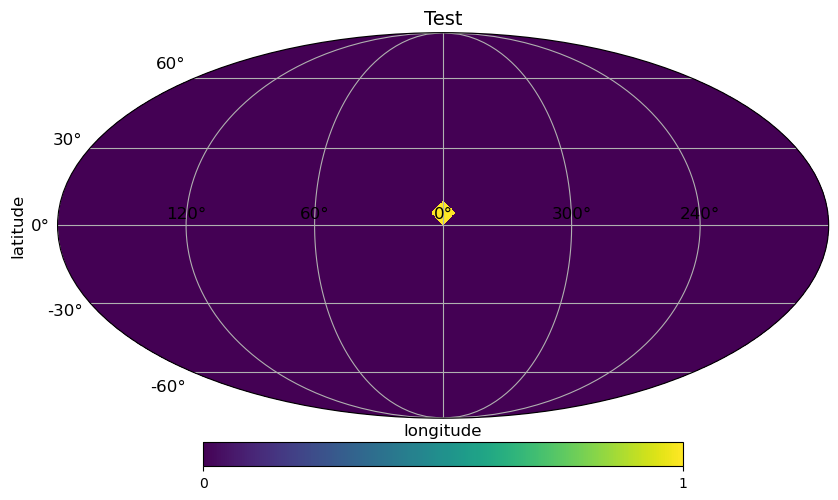

In [9]:
from shared.preface import *
from shared.shared_functions import *

Nside = 2**3  # Specified nside parameter, power of 2
Npix = 12 * Nside**2  # Number of pixels
pix_sr = (4*np.pi)/Npix  # Pixel size  [sr]

# '''
### --------------------------- ###
### Testing initial velocities. ###
### --------------------------- ###

# Galactic coordinates.
phi_angles, theta_angles = np.array(
    hp.pixelfunc.pix2ang(Nside, np.arange(Npix), lonlat=True)
)
ic(np.min(phi_angles), np.max(phi_angles))
# ic(theta_angles)

bt = 0
lt = 
# note: only works for positive l (phi), and pix2ang gives phi_angles [0, 2Pi]
theta_angles = theta_angles[np.abs(theta_angles - np.rad2deg(bt)).argmin()]
phi_angles = phi_angles[np.abs(phi_angles - np.rad2deg(lt)).argmin()]

glat = np.deg2rad(theta_angles)
glon = np.deg2rad(phi_angles)

# note: the choice of these 3 equations determines the orientation of x,y,z
# note: the signs of uX,uY,uZ corresponds to the directions of the spatial axes
uX = np.squeeze(np.array([np.cos(glat)*np.cos(glon)]))
uY = np.squeeze(np.array([np.cos(glat)*np.sin(glon)]))
uZ = np.squeeze(np.array([np.sin(glat)]))

u_proj_XY_plane_dis = np.sqrt(uX**2 + uY**2)

ic(f'{uX:.2f}') 
ic(f'{uY:.2f}')
ic(f'{uZ:.2f}')


thetas = np.arctan2(uZ, u_proj_XY_plane_dis)
phis = np.arctan2(uY, uX)

hp_glon, hp_glat = np.rad2deg(phis), np.rad2deg(thetas)

# Convert angles to pixel indices using ang2pix.
pixel_indices = hp.ang2pix(Nside, hp_glon, hp_glat, lonlat=True)

# Increment the corresponding pixels of empty healpix map.
healpix_map2 = np.zeros(Npix)
np.add.at(healpix_map2, pixel_indices, 1)

hp.newvisufunc.projview(
    healpix_map2,
    coord=['G'],
    title=f'Test',
    unit=r'',
    graticule=True,
    graticule_labels=True,
    xlabel="longitude",
    ylabel="latitude",
    cb_orientation="horizontal",
    projection_type="mollweide",
    flip='astro'
)
# '''


'''
### ---------------------- ###
### Testing DM projection. ###
### ---------------------- ###

DM_test = np.array([0, 0, 0])
obs_xyz = np.array([6.6, -6.6, -6.6])
DM_obs_cent = DM_test - obs_xyz
DM_proj_XY_plane_dis = np.sqrt(np.sum(DM_obs_cent[:2]**2, axis=-1))
DM_obs_dis = np.sqrt(np.sum(DM_obs_cent**2, axis=-1))

thetas = np.arctan2(DM_obs_cent[2], DM_proj_XY_plane_dis)
phis = np.arctan2(DM_obs_cent[1], DM_obs_cent[0])

hp_glon, hp_glat = np.rad2deg(phis), np.rad2deg(thetas)

# Convert angles to pixel indices using ang2pix.
pixel_indices = hp.ang2pix(Nside, hp_glon, hp_glat, lonlat=True)

# Increment the corresponding pixels of empty healpix map.
healpix_map = np.zeros(Npix)
np.add.at(healpix_map, pixel_indices, 1)

fig = plt.figure(figsize =(12, 6))
ax1 = fig.add_subplot(111)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
subax1 = 111

hp.newvisufunc.projview(
    healpix_map,
    coord=['G'],
    title=f'Test',
    unit=r'',
    graticule=True,
    graticule_labels=True,
    xlabel="longitude",
    ylabel="latitude",
    cb_orientation="horizontal",
    projection_type="mollweide",
    flip='astro',
    latitude_grid_spacing=45,
    longitude_grid_spacing=45,
    sub=subax1
)

# note: scatter has inverse x-axis, must take -phis (tested)
plt.scatter(-phis, thetas, c='red', s=20)
plt.show()

# '''

## Rotation matrices for DM projection to healpix map.

In [ ]:
from shared.preface import *
from shared.shared_functions import *

init_dis = 8.5
orig_xyz = np.array([init_dis, 0, 0.])
ic(orig_xyz)
xE = np.cos(np.deg2rad(Pi))*np.sin(np.deg2rad(Pi))*init_dis
yE = np.sin(np.deg2rad(Pi))*np.sin(np.deg2rad(Pi))*init_dis
zE = np.cos(np.deg2rad(Pi))*init_dis
init_xyz = np.array([xE, yE, zE])
# ic(init_xyz)

# Rotations happen in clockwise direction, when viewed from the positive top of 
# the axis around which rotation happends. 
# note: See GoodNotes drawing, for orientation of axes the functions assume.

# Earth was on x-axis originally. Applying matrix with positive angles will 
# result in going to the new earth frame, where now the original position is 
# seen from earths frame.
# This matrix must be used, to get all the DM in this new frame, such that we 
# can project it on the healpix map#!
order = 'zyx'
z_rot = Pi
y_rot = -Pi
x_rot = 0
rotation_mat_for_map = rotation_matrix(z_rot, y_rot, x_rot, order)
# ic(rotation_mat)
# angles = rotation_angles(rotation_mat, order)
# print(angles)
rot_xyz = np.matmul(rotation_mat_for_map, orig_xyz)
ic(rot_xyz)

# Rotation matrix with negative angles must be used, to get earths slightly 
# shifted position (needed for the cell edge issue) in the original frame, 
# where all the simulation happens#!
rotation_mat_for_sim = rotation_matrix(-z_rot, -y_rot, -x_rot, order)


### TEST ###

# Take a DM particle in the original frame with coordinates (x,y,z)_DM and 
# earth position in the same frame with (x,y,z)_E, where Earth is not 
# positioned on the x-axis. The only thing that we have to do, to "rotate" the 
# DM particle into the frame, where Earth is again on the x-axis connecting it 
# to the halo center, is to multiply (x,y,z)_DM by the rotation matrix, which 
# brought earth to be at the location in the original frame in the first place.

# note: We can get the galactic latitude and galactic longitude in the frame, where Earth lies on the x-axis (see drawings) connecting it to the halo center.

# Step 1: Original positions.
DM_test = np.array([-5, 1, 5])  # DM particle in original frame

# Offset Earth position from x-axis (because of the cell edge issue).
rot_mat = rotation_matrix(0, 0, 20, order)

# DM particle in earths frame.
DM_earth = np.matmul(rot_mat, DM_test)
ic('************')
ic(DM_test)
ic(DM_earth)

## Visual of all colorcet maps.

In [ ]:
from colorcet.plotting import swatch, swatches
import holoviews as hv
hv.extension('matplotlib')

swatches(group='diverging')

## Old stuff: to be analyzed and documented.

In [ ]:
def nu_in_which_cell(x_i, cell_coords, cell_gens, init_GRID_S):

    # print(x_i.shape)  # (3,)
    # print(cell_coords.shape)  # (cells, 1, 3)
    # print(cell_gens.shape)  # (cells,)

    # Center neutrino coords. on each cell center (whole grid).
    x_i = np.repeat(np.expand_dims(x_i, axis=(0,1)), len(cell_coords), axis=0)
    x_i -= cell_coords

    # All cell lengths. Limit for the largest cell is GRID_S/2, not just 
    # GRID_S, therefore the cell_gen+1 !
    cell_lens = np.expand_dims(init_GRID_S/(2**(cell_gens+1)), axis=1)
    # print(cell_lens.shape)  # (cells, 1)
    # print(x_i[...,0].shape)  # (cells, 1)

    # Find index of cell in which neutrino is enclosed.
    in_cell = np.asarray(
        (np.abs(x_i[...,0]) < cell_lens) & 
        (np.abs(x_i[...,1]) < cell_lens) & 
        (np.abs(x_i[...,2]) < cell_lens)
    )
    cell_idx = np.argwhere(in_cell==True).flatten()[0]  # np.int64

    return cell_idx


# Load files.
out_dir = 'L025N752/DMONLY/SigmaConstant00'
temp_dir = f'{out_dir}/temp_data_TEST'
cell_coords = np.load(f'{temp_dir}/fin_grid_origID28_snap_0014.npy')
cell_gens = np.load(f'{temp_dir}/cell_gen_origID28_snap_0014.npy')
init_GRID_S = np.load(f'{out_dir}/snaps_GRID_L.npy')[2]
print('Cells for this snap:', len(cell_coords))

with open(f'{out_dir}/sim_parameters.yaml', 'r') as file:
    sim_setup = yaml.safe_load(file)

init_dis = sim_setup['initial_haloGC_distance']
xE = np.cos(np.deg2rad(Pi))*np.sin(np.deg2rad(Pi))*init_dis
yE = np.sin(np.deg2rad(Pi))*np.sin(np.deg2rad(Pi))*init_dis
zE = np.cos(np.deg2rad(Pi))*init_dis
x_i = np.array([xE, yE, zE])*kpc

cell_idx = nu_in_which_cell(x_i, cell_coords, cell_gens, init_GRID_S)

In [ ]:
from itertools import zip_longest

x1 = np.arange(3)+6
x2 = np.arange(5)+6

y1 = np.arange(3)+25
y2 = np.arange(5)+25

lx1d = [x1,x2]
ly1d = [y1,y2]

arrx2d = np.array(list(zip_longest(*lx1d, fillvalue=np.nan))).T
arry2d = np.array(list(zip_longest(*ly1d, fillvalue=np.nan))).T

print(arrx2d)
print(arrx2d.shape)
print(arry2d)
print(arry2d.shape)

fin = np.stack((arrx2d, arry2d), axis=2)
print(fin)

In [ ]:
from itertools import product, combinations

arra = [[1,2],[3,4],[5,6]]
arrb = [4,5,6]
arrc = np.array(list(combinations(arra, 2)))
print(arrc)
print(np.product(arrc, axis=1))

In [ ]:
count_arr = np.arange(4)+2
print(count_arr)
count_arr[0] = 0.
count_arr[1] = 0.
count_arr[2] = 0.
# count_arr[3] = 0.
print(count_arr)

if np.all(count_arr==0):
    DM_axis0 = np.full(shape=(len(count_arr),1,3), fill_value=np.nan)
else:
    x_arr = np.arange(np.sum(count_arr))
    breaks = np.cumsum(count_arr[:-1])
    x_split = np.split(x_arr, breaks)
    # print(x_split)
    DM_axis0 = np.array(list(zip_longest(*x_split, fillvalue=np.nan))).T


print(DM_axis0)

In [ ]:
DM_count_mpoles = np.array([2])

x_arr = np.arange(np.sum(DM_count_mpoles))
breaks = np.cumsum(DM_count_mpoles[:-1])
x_split = np.split(x_arr, breaks)
print(x_split)
DM_axis0 = np.array(list(zip_longest(*x_split, fillvalue=np.nan))).T
DM_axis1 = np.array(list(zip_longest(*x_split, fillvalue=np.nan))).T
DM_axis2 = np.array(list(zip_longest(*x_split, fillvalue=np.nan))).T
print(DM_axis0)
DM_mpoles = np.stack((DM_axis0, DM_axis1, DM_axis2), axis=2)
print(DM_mpoles)

shapes/nums: 267 (267,) 1 (3,) (267, 3) (267,) 394.0 (1, 457240, 3) (267,) (457239, 2)

In [ ]:
from shared.preface import *
import shared.functions as fct

PRE = PRE(
    sim='L025N752', 
    z0_snap=36, z4_snap=13, DM_lim=1000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=20, thetas=20, vels=200,
    pre_CPUs=10, sim_CPUs=128
)


# Make temporary folder to store files, s.t. parallel runs don't clash.
rand_code = ''.join(
    random.choices(string.ascii_uppercase + string.digits, k=4)
)
TEMP_DIR = f'{PRE.OUT_DIR}/temp_data_{rand_code}'
os.makedirs(TEMP_DIR)

Testing = False
if Testing:
    mass_gauge = 12.3
    mass_range = 0.3
    size = 1
else:
    mass_gauge = 12.0
    mass_range = 0.6
    size = 10

hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
fct.halo_batch_indices(
    PRE.Z0_STR, mass_gauge, mass_range, 'halos', size, 
    hname, PRE.SIM_DIR, TEMP_DIR
)
halo_batch_IDs = np.load(f'{TEMP_DIR}/halo_batch_{hname}_indices.npy')
halo_batch_params = np.load(f'{TEMP_DIR}/halo_batch_{hname}_params.npy')
halo_num = len(halo_batch_params)

print('********Number density band********')
print('Halo batch params (Rvir,Mvir,cNFW):')
print(halo_batch_params)
print('***********************************')

# Remove temporary folder with all individual neutrino files.
shutil.rmtree(TEMP_DIR)

In [ ]:
from shared.preface import *
import shared.functions as fct

# Initialize parameters and files.
PRE = PRE(
    sim='L012N376', 
    z0_snap=36, z4_snap=13, DM_lim=1000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=10, thetas=10, vels=100,
    pre_CPUs=6, sim_CPUs=6
)

Testing=False
if Testing:
    mass_gauge = 12.3
    mass_range = 0.3
    size = 1
else:
    mass_gauge = 12.0
    mass_range = 0.6
    size = 10

hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
fct.halo_batch_indices(
    PRE.Z0_STR, mass_gauge, mass_range, 'halos', size, 
    hname, PRE.SIM_DIR, PRE.OUT_DIR
)
halo_batch_IDs = np.load(f'{PRE.OUT_DIR}/halo_batch_{hname}_indices.npy')
halo_batch_params = np.load(f'{PRE.OUT_DIR}/halo_batch_{hname}_params.npy')
halo_num = len(halo_batch_params)

print('********Number density band********')
print('Halo batch params (Rvir,Mvir,cNFW):')
print(halo_batch_params)
print('***********************************')

# Tests for CubeSpace components.

# Tests for functions in shared/functions.py

### Optimal momentum spacing.

In [ ]:
from shared.preface import *
import shared.functions as fct

Vs = 200
LOWER = 0.01*T_CNB
UPPER = 10*T_CNB

fig, ax = plt.subplots(1,1)

v_tot_min = 1/np.sqrt(NU_MASSES[-1]**2/LOWER**2 + 1) / (kpc/s)
v_tot_max = 1/np.sqrt(NU_MASSES[0]**2/UPPER**2 + 1) / (kpc/s)
v_lines = np.geomspace(v_tot_min, v_tot_max, 5)

v_tot_geo = np.geomspace(v_tot_min, v_tot_max, Vs)
ax.scatter(v_tot_geo, v_tot_geo+(1.1*v_tot_geo), s=2)

for v0, v1 in zip(v_lines[:-1], v_lines[1:]):
    v_segment = np.geomspace(v0, v1, int(Vs/4))
    ax.scatter(v_segment, v_segment, s=2)
    ax.axvline(v0, ls=':', c='r')

plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
from shared.preface import *
import shared.functions as fct


fig, ax = plt.subplots(1,1)

momenta = np.geomspace(0.01*T_CNB, 10*T_CNB, 100)
v_kpc = 1/np.sqrt(NU_MASS**2/momenta**2 + 1) / (kpc/s)  # rel. formula
ax.scatter(v_kpc, v_kpc, s=2)

# plt.xscale('log')
# plt.yscale('log')
plt.show()

### Conversions between momentum to velocity.

In [ ]:
from shared.preface import *
import shared.functions as fct

Vs = 100
LOWER = 0.01*T_CNB
UPPER = 400.*T_CNB

# Momentum range.
MOMENTA = np.geomspace(LOWER, UPPER, Vs)
NU_MASSES = np.array([0.01, 0.05, 0.1, 0.3])

# Without Lorentz factor.
v_mins = np.zeros(len(NU_MASSES))
v_maxs = np.zeros(len(NU_MASSES))
for i, m_nu in enumerate(NU_MASSES):
    v_km = MOMENTA / m_nu / (m/s)
    v_min, v_max = v_km[0], v_km[-1]
    print(f'(m/s) -> v_min = {v_min:.2f}, v_max = {v_max:.2f}, %c = {v_max/const.c.value*100:.2f} : for {m_nu} eV neutrino')

    v_mins[i] = v_min
    v_maxs[i] = v_max

# With Lorentz factor.
v_mins = np.zeros(len(NU_MASSES))
v_maxs = np.zeros(len(NU_MASSES))
for m_nu in NU_MASSES:
    v_km = 1/np.sqrt(m_nu**2/MOMENTA**2 + 1) / (m/s)
    v_min, v_max = v_km[0], v_km[-1]
    print(f'(m/s) -> v_min = {v_min:.2f}, v_max = {v_max:.2f}, %c = {v_max/const.c.value*100:.2f} : for {m_nu} eV neutrino')

#! Since the sim is using 0.3 eV mass, the max. velocity present in the sim is 
#! ~20% of c, not the ~98% of the 0.01 eV neutrino (see output of cell).

# Back to momentum to check formulas & functions.

### Coordinates of Andromeda (AG) and the Virgo Cluster (VC).

In [ ]:
# Cross-check with values in Mertsch et al. (2020).
# -> x and y coords. are switched, since our setup is different,
# and my x (their y) coords. differ by 8.5 kpc due to placement of sun
# on our x-axis.
coords_VC = fct.halo_pos(GLAT_VC, GLON_VC, DIST_VC/kpc)
print(coords_VC, 'in kpc')
coords_AG = fct.halo_pos(GLAT_AG, GLON_AG, DIST_AG/kpc)
print(coords_AG, 'in kpc')

### Values in Table 1 of Mertsch et al. (2020).

In [ ]:
Rvir_Tab1 = fct.R_vir_fct(0, Mvir_MW)
print(Rvir_Tab1/kpc)
c_vir_Tab1 = fct.c_vir(0, Mvir_MW, Rvir_MW, Rs_MW)
Rs_Tab1 = Rvir_Tab1 / c_vir_Tab1
print(Rs_Tab1/kpc)

### Critical density of universe.

In [ ]:
rho_crit_today = fct.rho_crit(0)
print(f'{rho_crit_today*(Msun/kpc**3)/(kg/m**3):.2e} kg/m^3') 

### Time Variable s(z) and comparison to age of universe.

In [ ]:
# In s_of_z function we use
H0_mod = H0/ (1/s)
print(H0_mod)

test_z = 1
s_val = fct.s_of_z(test_z)
print(f'Value of time variable s in seconds at redhshift {test_z}:','\n', s_val)
print(
    'Age of universe comparison: \n', 
    f'"Observed/measured": {t0/s:.2e}, i.e. {t0/Gyr:.2f} Gyr \n', 
    f'What we use in s_of_z function: {1/H0/s:.2e}, i.e. {1/H0/Gyr:.2f} Gyr'
)

### Integrals for cosmic time.

In [ ]:
def t_integrand_a(a):

    # We need value of H0 in units of 1/s.
    H0_val = H0/(1/s)

    a_dot = np.sqrt(Omega_M/a**3 + Omega_L)*H0_val*a
    t_int = 1./a_dot

    return t_int

t, err = quad(t_integrand_a, 0, 1)
t_uni, err_uni = t, err
print(t_uni*s/Gyr, err_uni*s/Gyr)

In [ ]:
def t_integrand_z(z):

    # We need value of H0 in units of 1/s.
    H0_val = H0/(1/s)

    a_dot = np.sqrt(Omega_M*(1.+z)**3 + Omega_L)*H0_val*(1.+z)
    t_int = 1./a_dot

    return t_int

t, err = quad(t_integrand_z, 0, np.inf)
t_uni, err_uni = t, err
print(t_uni*s/Gyr, err_uni*s/Gyr)

### Fermi-Dirac distribution.

In [ ]:
p_test_range = np.linspace(0.01, 10)*T_CNB
FD_range = fct.Fermi_Dirac(p_test_range)

plt.loglog(p_test_range/T_CNB, FD_range)
plt.show()

### Redshift array for integration steps.

In [ ]:
# Linear spacing.
# late_steps = 200
# early_steps = 100
# Z_START, Z_STOP, Z_AMOUNT = 0., 4., late_steps+early_steps
# z_late = np.linspace(0,1,late_steps)
# z_early = np.linspace(1.01,4,early_steps)
# ZEDS = np.concatenate((z_late, z_early))

# Logarithmic spacing.
Z_AMOUNT = 50
z_shift = 1e-1
ZEDS = np.geomspace(z_shift, 4.+z_shift, Z_AMOUNT) - z_shift

plt.scatter(ZEDS, ZEDS, s=1)
plt.scatter(ZEDS_SNAPSHOTS, ZEDS_SNAPSHOTS+0.1, s=1)
plt.show()
print(ZEDS[0:10], ZEDS[-1])

### NFW density profile fct.

In [ ]:
r_range = np.geomspace(1e-3, 100, 100)*kpc
NFW_vals = fct.NFW_profile(r_range, rho0_MW, Rs_MW)
plt.loglog(r_range/kpc, NFW_vals/(GeV/cm**3))

### Typical grav. potential gradient vectors in spher. symmetric simulation.

In [ ]:
z = 0

# For position of Sun/Earth.
x_i = X_SUN*kpc
grad_MW = fct.dPsi_dxi_NFW(x_i, z, rho0_MW, Mvir_MW, Rvir_MW, Rs_MW, 'MW')
grad_MW /= (kpc/s**2)
print('Position of Sun/Earth:')
print(grad_MW)
print(np.sqrt(np.sum(grad_MW**2)), '\n')

# For a position closer to the center of the halo.
x_i = np.array([0.01, 0, 0])*kpc
grad_MW = fct.dPsi_dxi_NFW(x_i, z, rho0_MW, Mvir_MW, Rvir_MW, Rs_MW, 'MW')
grad_MW /= (kpc/s**2)
print('Position close to center:')
print(grad_MW)
print(np.sqrt(np.sum(grad_MW**2)), '\n')

# For a position further away to the center of the halo.
x_i = np.array([333., 0, 0])*kpc
grad_MW = fct.dPsi_dxi_NFW(x_i, z, rho0_MW, Mvir_MW, Rvir_MW, Rs_MW, 'MW')
grad_MW /= (kpc/s**2)
print('Position at virial radius:')
print(grad_MW)
print(np.sqrt(np.sum(grad_MW**2)))